In [40]:
application = 'Innovation_Vineyards'

In [41]:
%matplotlib inline

In [42]:
import pathlib
from calendar import month_abbr

In [43]:
from matplotlib import pyplot as plt 

In [44]:
import pandas as pd

In [45]:
import numpy as np

In [46]:
HOME = pathlib.Path.home()

In [47]:
def demean(x): 
    return x - x.loc['1981':'2010',:].mean() 

### some definitions here 

In [48]:
exceedances = [20,25,30]

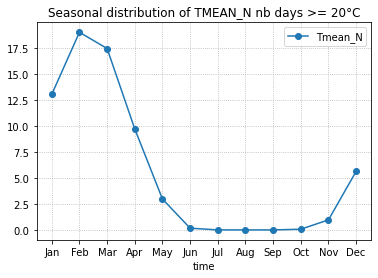

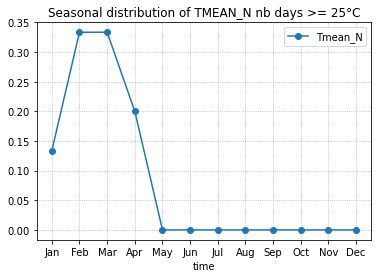

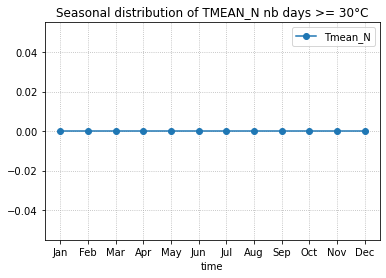

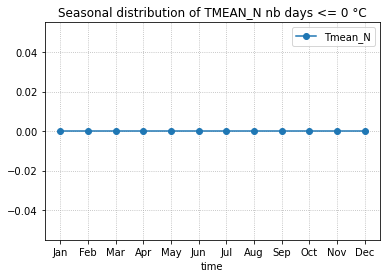

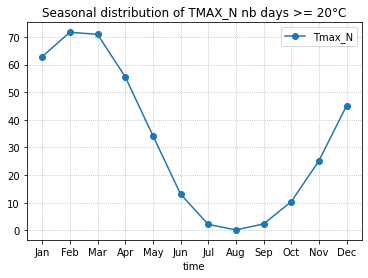

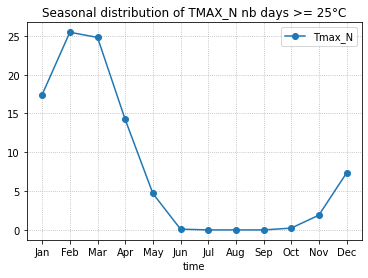

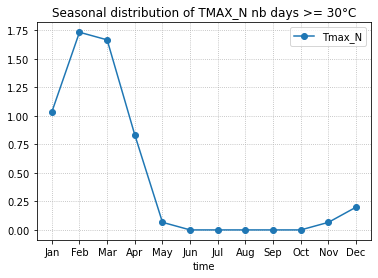

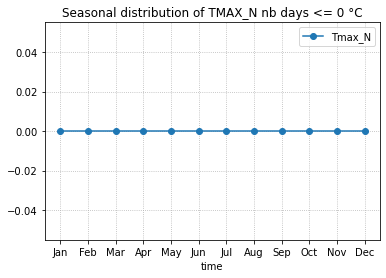

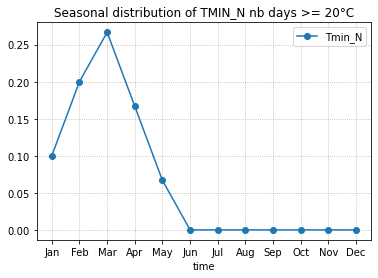

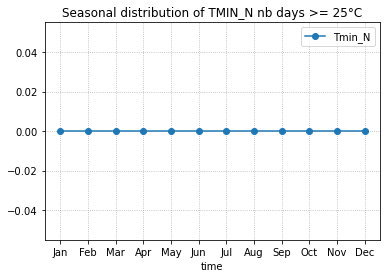

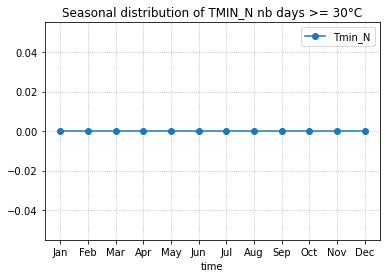

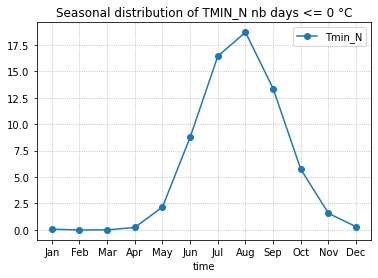

In [49]:
for varname in ['TMEAN_N', 'TMAX_N', 'TMIN_N']: 
    
    dpath = HOME.joinpath(f"research/Smart_Ideas/outputs/targets/application_cases/{application}/DAILY/{varname}")
    
    lfiles = list(dpath.glob("*.csv"))
    
    data = pd.read_csv(dpath.joinpath(f"Daily_{varname}.csv"), index_col=0, parse_dates=True)
    
    ## remove lat and lon 
    data = data.iloc[:,[-1]]

    ## ----------------------------------------------------------------------------------------------- 
    ## calculates the seasonal averages 
    df_m = data.resample('1M').mean()
    df_s = df_m.rolling(window=3, min_periods=3).mean()

    df_s = df_s.iloc[2:,:]

    opath_seasonal = HOME.joinpath(f"research/Smart_Ideas/outputs/targets/application_cases/{application}/SEASONAL/{varname}")

    if not opath_seasonal.exists(): 
        opath_seasonal.mkdir(parents=True)

    df_s.to_csv(opath_seasonal.joinpath(f"Seasonal_{varname}_mean.csv"))
    
    ## calculates the anomalies and saves to disk 
    
    anoms = df_s.groupby(df_s.index.month).apply(demean)
    
    anoms.to_csv(opath_seasonal.joinpath(f"Seasonal_{varname}_anomalies.csv"))

    ## ----------------------------------------------------------------------------------------------- 
    ## now calculates the exceedances (nb of days ABOVE threshold)
    for thresh in exceedances: 

        ### keep all the instances where values exceed thresholds, the other are set to `np.NaN`
        df = data.where((data >= thresh))

        ### set all instances that are non-null to 1
        df = df.where(df.isnull(), 1)

        ### number of days per month above the threshold
        df_m = df.resample('1M').sum()

        ### adds the number of days in month, in case we want to calculate the proportion 
        df_m.loc[:,'ndays'] = df_m.index.days_in_month 

        ### 3 months rolling accumulation 
        df_s = df_m.rolling(window=3, min_periods=3).sum()

        ### remove the missing values 
        df_s = df_s.iloc[2:,:]

        ### saves to disk 
        df_s.to_csv(opath_seasonal.joinpath(f"Seasonal_{varname}_nbdays_over_{thresh}C.csv"))

        ### plots the seasonal distribution of the number of days below threshold (1981-2010 climatology)
        clim = df_s.loc['1981':'2010',:]

        f, ax = plt.subplots()
        clim.groupby(clim.index.month).mean().iloc[:,:-1].plot(ax=ax, marker='o')
        ax.grid(ls=':')
        ax.set_xticks(np.arange(1,12+1))
        ax.set_xticklabels(month_abbr[1:]); 
        ax.set_title(f"Seasonal distribution of {varname} nb days >= {thresh}\u00B0C")
        
        f.savefig(f'../figures/seasonal_distribution_{varname}_above_{thresh}C.png', dpi=200, bbox_inches='tight')

    # calculate number of days BELOW threshold 
    thresh = 0

    ### keep all the instances where values exceed thresholds, the other are set to `np.NaN`
    df = data.where((data <= thresh))

    ### set all instances that are non-null to 1
    df = df.where(df.isnull(), 1)

    ### number of days per month above or below the threshold
    df_m = df.resample('1M').sum()

    ### adds the number of days in month, in case we want to calculate the proportion 
    df_m.loc[:,'ndays'] = df_m.index.days_in_month 

    ### 3 months rolling accumulation 
    df_s = df_m.rolling(window=3, min_periods=3).sum()

    ### remove the missing values 
    df_s = df_s.iloc[2:,:]

    ### saves to disk 
    df_s.to_csv(opath_seasonal.joinpath(f"Seasonal_{varname}_nbdays_below_{thresh}C.csv"))

    ### plots the seasonal distribution of the number of days below threshold 
    clim = df_s.loc['1981':'2010',:]

    f, ax = plt.subplots()
    clim.groupby(clim.index.month).mean().iloc[:,:-1].plot(ax=ax, marker='o')
    ax.grid(ls=':')
    ax.set_xticks(np.arange(1,12+1))
    ax.set_xticklabels(month_abbr[1:]); 
    ax.set_title(f"Seasonal distribution of {varname} nb days <= {thresh} \u00B0C")
    f.savefig(f'../figures/seasonal_distribution_{varname}_below_{thresh}C.png', dpi=200, bbox_inches='tight')